This tutorial demonstrates how to use FEniCS and the `phaseflow.Simulation` class as an application programming interface (API) for implementing time-dependent simulations with goal-oriented adaptive mesh refinement (AMR).

First, import Phaseflow and FEniCS.

In [11]:
import phaseflow
import fenics

To implement a simulation, we must define a class which inherits from Phaseflow's `Simulation` class. Some of the methods of `Simulation` must be overloaded or they will otherwise throw an error. These are analogous to `pure virtual` methods in C++. In this tutorial, we will define a minimal example which only overloads the required methods. 

First we implement the unsteady incompressible Navier-Stokes equations in variational form, including the dynamic viscosity as a parameter.

In [2]:
class Simulation(phaseflow.simulation.Simulation):

    def __init__(self):
        """ Extend the constructor with parameters for this simulation. """
        phaseflow.simulation.Simulation.__init__(self)
        
        self.dynamic_viscosity = 0.01
        
        
    def setup_element(self):
        """ Set the P2P1 (Taylor-Hood) mixed element. """
        pressure_element = fenics.FiniteElement("P", self.mesh.ufl_cell(), 1)
        
        velocity_element = fenics.VectorElement("P", self.mesh.ufl_cell(), 2)
        
        self.element = fenics.MixedElement([pressure_element, velocity_element])
        
        
    def setup_governing_form(self):
        """ Set the variational form for the governing equations. """
        p, u = fenics.split(self.state.solution)
        
        p_n, u_n = fenics.split(self.old_state.solution)
        
        Delta_t = fenics.Constant(self.timestep_size)
        
        u_t = (u - u_n)/Delta_t
        
        mu = fenics.Constant(self.dynamic_viscosity)
        
        psi_p, psi_u = fenics.TestFunctions(self.function_space)
        
        dx = self.integration_metric
        
        inner, dot, grad, div, sym = \
            fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
        
        mass = -psi_p*div(u)
        
        momentum = dot(psi_u, u_t + dot(grad(u), u)) - div(psi_u)*p \
            + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))
            
        self.governing_form = (mass + momentum)*dx

Next we define a simulation for the lid-driven cavity benchmark problem. While the benchmark is usually only considered at steady state, with small time step sizes we can observe the unsteady evolution of the velocity field which eventually reaches steady state.

In [12]:
class LidDrivenCavitySimulation(Simulation):
    """ Implements the well-known lid-driven cavity benchmark. """
    def __init__(self):
        """Extend the constructor with attributes for this simulation. """
        Simulation.__init__(self)
        
        self.lid_horizontal_velocity = 1.
        
        
    def setup_coarse_mesh(self):
        """ This creates a coarse mesh on the unit square. """
        self.mesh = fenics.UnitSquareMesh(2, 2, "crossed")
    
    
    def setup_derived_attributes(self):
        """ Set some attributes which should not be touched by the user. """
        Simulation.setup_derived_attributes(self)
        
        self.walls = {"left": "near(x[0],  0.)", "right": "near(x[0],  1.)",
            "bottom": "near(x[1],  0.)", "top": "near(x[1],  1.)"}
        
        self.lid = self.walls["top"]
        
        self.fixed_walls = self.walls["left"] + " + " + self.walls["right"] + \
         " + " + self.walls["bottom"]
        
        self.boundary_conditions = [
            {"subspace": 1, "location": self.lid, 
             "value": (self.lid_horizontal_velocity, 0.)},
            {"subspace": 1, "location": self.fixed_walls, 
             "value": (0., 0.)}]
        
    
    def setup_adaptive_goal_form(self):
        """ Set an adaptive goal based on the horizontal velocity. """
        p, u = fenics.split(self.state.solution)
        
        self.adaptive_goal_form = u[0]*u[0]*self.integration_metric
    
    
    def setup_initial_values(self):
        """ Set initial values which are consistent with the boundary conditions. """
        p, ux, uy = "0.", self.lid + "*" + str(self.lid_horizontal_velocity), "0."
        
        self.old_state.interpolate((p, ux, uy))

Now we instantiate our simulation

In [4]:
sim = LidDrivenCavitySimulation()

and run it for a time step.

In [5]:
sim.timestep_size = 1.

sim.end_time = 0. + sim.timestep_size

sim.adaptive_goal_tolerance = 1.e-4

sim.run()

Writing solution to phaseflow/output//solution.xdmf
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t1.0.h5
Reached end time, t = 1.0


Before continuing, let's see how the solution and the adapted mesh look.

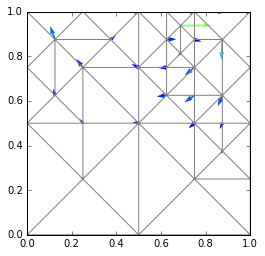

In [6]:
%matplotlib inline

p, u = sim.state.solution.leaf_node().split()

fenics.plot(u)

fenics.plot(sim.mesh.leaf_node())

This looks somewhat reasonable. Let's run for a few more time steps and check again.

Reached time t = 1.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t2.0.h5
Reached time t = 2.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t3.0.h5
Reached end time, t = 3.0


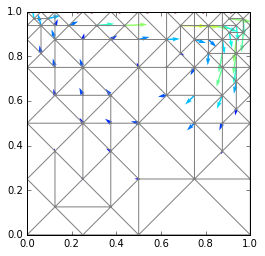

In [7]:
sim.end_time = 3.*sim.timestep_size

sim.run()

p, u = sim.state.solution.leaf_node().split()

fenics.plot(u)

fenics.plot(sim.mesh.leaf_node())

Let's try some larger time steps. Since the time step size is a parameter in the governing equations, we must setup the variational problem again.

Reached time t = 3.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t13.0.h5
Reached time t = 13.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t23.0.h5
Reached time t = 23.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t33.0.h5
Reached end time, t = 30.0


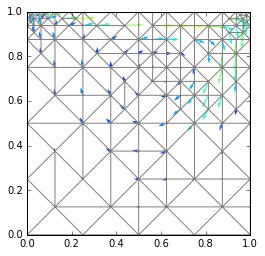

In [8]:
sim.timestep_size *= 10.

sim.setup_problem_and_solver()

sim.end_time = 3.*sim.timestep_size

sim.run()

p, u = sim.state.solution.leaf_node().split()

fenics.plot(u)

fenics.plot(sim.mesh.leaf_node())

We can quantify how quickly the solution is changing in time:

In [9]:
p_n, u_n = sim.old_state.solution.leaf_node().split()

fenics.errornorm(u, u_n, "L2")

0.003115213613162482

The time residual is still significant. Let's see what happens when we take a couple of arbitrarily large time steps, which approximates the steady state solution.

Reached time t = 33.0
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t1e+32.h5
Reached time t = 1e+32
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t2e+32.h5
Reached time t = 2e+32
Writing solution to phaseflow/output//solution.xdmf
Writing checkpoint file to phaseflow/output/checkpoint_t3e+32.h5
Reached end time, t = 2e+32


0.0

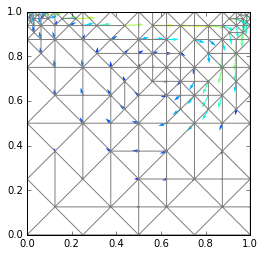

In [10]:
sim.timestep_size = 1.e32

sim.setup_problem_and_solver()

sim.end_time = 2.*sim.timestep_size

sim.run()

p, u = sim.state.solution.leaf_node().split()

fenics.plot(u)

fenics.plot(sim.mesh.leaf_node())

p_n, u_n = sim.old_state.solution.leaf_node().split()

fenics.errornorm(u, u_n, "L2")

Now the time residual is zero, i.e. we have reached steady state.